##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 2 quickstart for experts

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/advanced"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook file. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.

Download and install TensorFlow 2. Import TensorFlow into your program:

Note: Upgrade `pip` to install the TensorFlow 2 package. See the [install guide](https://www.tensorflow.org/install) for details.

Import TensorFlow into your program:

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

Use `tf.data` to batch and shuffle the dataset:

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [ ]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

Choose an optimizer and loss function for training:

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

Test the model:

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_state()
  train_accuracy.reset_state()
  test_loss.reset_state()
  test_accuracy.reset_state()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result():0.2f}, '
    f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
    f'Test Loss: {test_loss.result():0.2f}, '
    f'Test Accuracy: {test_accuracy.result() * 100:0.2f}'
  )

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials).

In [ ]:
#%%
# samv.py -- readable SAMV implementation (power-based iterative SAMV)
from tqdm import tqdm
import numpy as np
from numpy.linalg import inv, LinAlgError, eigvals
import matplotlib.pyplot as plt
from scipy import sparse
import tensorflow as tf


# ------------------- helper functions -------------------
def steering_vector_ula(M, theta_deg, spacing=0.5):
    """
    ULA steering vectors (columns): M x len(theta_deg)
    spacing in wavelengths (default 0.5 -> half-wavelength)
    """
    theta = np.atleast_1d(theta_deg) * np.pi / 180.0
    m = np.arange(M)
    A = np.exp(-1j * 2 * np.pi * spacing * np.outer(m, np.sin(theta)))
    A = A / np.sqrt(M)   # column normalization
    return A
import numpy as np

def system_matrix_parallel_beam(n_pix=200, n_detectors=100, n_angles=180, extent=1.0):
    """
    Build a parallel-beam system matrix for 2D CT.

    Parameters
    ----------
    n_pix : int
        Number of pixels per dimension (image is n_pix x n_pix).
    n_detectors : int
        Number of detector bins per projection angle.
    n_angles : int
        Number of projection angles (rays are parallel).
    extent : float
        Physical width/height of image (square) in arbitrary units.

    Returns
    -------
    A : ndarray, shape (M, K)
        System matrix mapping image (flattened) -> sinogram (flattened).
    xgrid, ygrid : ndarray
        Pixel center coordinates for reshaping reconstruction.
    angles : ndarray
        Projection angles in radians.
    """
    # Pixel grid
    x = np.linspace(-extent/2, extent/2, n_pix)
    y = np.linspace(-extent/2, extent/2, n_pix)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    Xc, Yc = np.meshgrid(x, y, indexing='xy')
    pixel_centers = np.column_stack((Xc.ravel(), Yc.ravel()))

    # Angles
    angles = np.linspace(0, np.pi, n_angles, endpoint=False)

    # Detector positions (perpendicular to ray direction)
    det_pos = np.linspace(-extent/2, extent/2, n_detectors)

    # Allocate system matrix
    M = n_detectors * n_angles
    K = n_pix * n_pix
    A = np.zeros((M, K))

    # For each angle, build rays
    for a_idx, th in enumerate(angles):
        # Unit vector along ray direction
        ray_dir = np.array([np.cos(th), np.sin(th)])
        # Perpendicular vector (detector axis)
        det_axis = np.array([-np.sin(th), np.cos(th)])

        for d_idx, d in enumerate(det_pos):
            row = a_idx * n_detectors + d_idx

            # Ray passes through all pixels, we approximate weight
            # using distance from pixel center to ray line.
            # (This is a crude projector; for high quality use ASTRA toolbox).
            dist = np.dot(pixel_centers, det_axis) - d
            mask = np.abs(dist) < max(dx, dy)/2   # select pixels near ray
            A[row, mask] = 1.0   # mark hit pixels with weight 1
            # You can refine by assigning proportional to (1 - |dist|/pixel_size).

    return A, x, y, angles

def system_matrix(n_pixels=200, n_projections=1500, extent=1.0):
    """
    Build tomography system matrix A (M x K).
    - detectors: array of detector bin positions
    - angles: array of projection angles (radians)
    - pixel_grid: list of candidate pixel positions (x,y)
    Each column of A = contribution of one pixel to all sinogram measurements.
    """
    x = np.linspace(-extent/2, extent/2, n_pixels)
    dx = x[1] - x[0]

    # Projection angles uniformly in [0, pi)
    angles = np.linspace(0, np.pi, n_projections, endpoint=False)

    # For a 1D object, projection is just cos(theta) weighting
    # (This is a toy model — in 2D CT you need full line integrals.)
    A = np.zeros((n_projections, n_pixels))
    for i, th in enumerate(angles):
        # Effective projection profile
        A[i, :] = np.abs(np.cos(th)) * dx  # each ray integrates over all pixels
    return A, x, angles

def sample_covariance(X):
    """R_N = (1/N) X X^H, X is M x N"""
    M, N = X.shape
    return (X @ X.conj().T) / N

def estimate_noise_by_min_eig(Rn, floor=1e-6):
    """Simple noise init: smallest eigenvalue (clipped)."""
    vals = np.real(eigvals(Rn))
    return max(np.min(vals), floor)


# ------------------- SAMV algorithm -------------------
def samv_tf(X, A, p0=None, sigma0=None,
            max_iters=200, tol=1e-6,
            min_p=1e-12, min_sigma=1e-8,
            reg_coef=1e-8,
            gamma_p=0.3, gamma_sigma=0.3,
            verbose=False):
    """
    TensorFlow GPU-accelerated SAMV.
    Inputs:
      - X: [M, N] tf.complex64
      - A: [M, K] tf.complex64
    Returns:
      - p: [K] estimated powers (tf.float32)
      - sigma: scalar noise variance
    """

    M, N = X.shape
    _, K = A.shape

    # Sample covariance Rn = (1/N) X X^H
    Rn = (X @ tf.transpose(tf.math.conj(X))) / tf.cast(N, tf.complex64)

    # Init p
    if p0 is None:
        p = tf.ones([K], dtype=tf.float32) * 1e-2
    else:
        p = tf.convert_to_tensor(p0, dtype=tf.float32)

    # Init sigma
    if sigma0 is None:
        eigvals = tf.linalg.eigvalsh(tf.math.real(Rn))
        sigma = tf.reduce_max([tf.reduce_min(eigvals), min_sigma])
    else:
        sigma = tf.constant(float(sigma0), dtype=tf.float32)

    history = {'p': [], 'sigma': []}

    eps = 1e-12

    for it in range(max_iters):
        history['p'].append(p.numpy())
        history['sigma'].append(sigma.numpy())

        # Diagonal power matrix implicitly via elementwise multiply
        # R = A diag(p) A^H + sigma I
        AP = A * tf.cast(p[tf.newaxis, :], tf.complex64)   # broadcast multiply
        R = AP @ tf.transpose(tf.math.conj(A)) + tf.cast(sigma, tf.complex64) * tf.eye(M, dtype=tf.complex64)

        # Regularize
        R_reg = tf.cast(reg_coef, tf.float32) * tf.cast(tf.linalg.trace(R), tf.float32) / M
        R = R + tf.cast(R_reg, tf.complex64) * tf.eye(M, dtype=tf.complex64)

        # Inverse via solve (better than tf.linalg.inv)
        # Solve R Y = Rn

        # Solve R Z = Yᴴ


        Rinv = tf.linalg.inv(R)

        Rinv_Rn_Rinv = Rinv @ Rn @ Rinv
        Rinv2 = Rinv @ Rinv

        # ----- Vectorized power update -----
        # denom[k] = a_k^H Rinv a_k
        # numer[k] = a_k^H Rinv_Rn_Rinv a_k
        denom = tf.reduce_sum(tf.math.conj(A) * (Rinv @ A), axis=0)
        numer = tf.reduce_sum(tf.math.conj(A) * (Rinv_Rn_Rinv @ A), axis=0)

        denom = tf.math.real(denom) + eps
        numer = tf.math.real(numer)

        p_update = numer / (denom**2) + p - 1.0 / denom
        p_update = tf.where(tf.math.is_finite(p_update), p_update, p)
        p_candidate = tf.maximum(min_p, (1 - gamma_p) * p + gamma_p * p_update)

        # ----- Sigma update -----
        trace_Rinv2 = tf.math.real(tf.linalg.trace(Rinv2))
        if tf.abs(trace_Rinv2) < eps:
            sigma_candidate = sigma
        else:
            term = tf.math.real(tf.linalg.trace(Rinv2 @ Rn)) \
                 + sigma * trace_Rinv2 \
                 - tf.math.real(tf.linalg.trace(Rinv))
            sigma_update = term / trace_Rinv2
            sigma_update = tf.cond(tf.math.is_finite(sigma_update),
                                   lambda: sigma_update, lambda: sigma)
            sigma_candidate = tf.maximum(min_sigma, (1 - gamma_sigma) * sigma + gamma_sigma * sigma_update)

        # Convergence check
        max_change = tf.reduce_max(tf.abs(p_candidate - p))
        max_change = tf.maximum(max_change, tf.abs(sigma_candidate - sigma))

        p, sigma = p_candidate, sigma_candidate

        if verbose and (it % 10 == 0 or it == max_iters-1):
            print(f"iter={it+1}, max_change={max_change.numpy():.3e}, sum(p)={tf.reduce_sum(p).numpy():.3e}, sigma={sigma.numpy():.3e}")

        if max_change < tol:
            break

    return p, sigma, history

def samv_tf_stochastic(X, A, n_detectors, n_angles,
                       n_angle_samples=10,
                       max_iters=200, tol=1e-6,
                       min_p=1e-12, min_sigma=1e-8,
                       reg_coef=1e-8,
                       gamma_p=0.3, gamma_sigma=0.3,
                       verbose=False):
    """
    Stochastic SAMV: at each iteration, sample a subset of angles.
    """

    M, N = X.shape
    _, K = A.shape

    # init
    p = tf.ones([K], dtype=tf.float32) * 1e-2
    p[0,0]=1
    sigma = tf.constant(1e-3, dtype=tf.float32)

    history = {'p': [], 'sigma': []}

    eps = 1e-12

    for it in range(max_iters):
        # ---- randomly choose angles ----
        angle_idx = tf.random.shuffle(tf.range(n_angles))[:n_angle_samples]
        rows = tf.reshape(angle_idx[:,None] * n_detectors + tf.range(n_detectors)[None,:], [-1])
        A_sub = tf.gather(A, rows, axis=0)
        X_sub = tf.gather(X, rows, axis=0)

        M_sub = tf.shape(A_sub)[0]
        N_sub = tf.shape(X_sub)[1]

        # sample covariance
        Rn = (X_sub @ tf.transpose(tf.math.conj(X_sub))) / tf.cast(N_sub, tf.complex64)

        # R = A diag(p) A^H + sigma I
        AP = A_sub * tf.cast(p[tf.newaxis, :], tf.complex64)
        R = AP @ tf.transpose(tf.math.conj(A_sub)) + tf.cast(sigma, tf.complex64) * tf.eye(M_sub, dtype=tf.complex64)

        # regularize
        R_reg = reg_coef * tf.cast(tf.linalg.trace(R), tf.float32) / tf.cast(M_sub, tf.float32)
        R = R + tf.cast(R_reg, tf.complex64) * tf.eye(M_sub, dtype=tf.complex64)

        # inverse
        Rinv = tf.linalg.inv(R)
        Rinv_Rn_Rinv = Rinv @ Rn @ Rinv
        Rinv2 = Rinv @ Rinv

        # vectorized update
        denom = tf.reduce_sum(tf.math.conj(A_sub) * (Rinv @ A_sub), axis=0)
        numer = tf.reduce_sum(tf.math.conj(A_sub) * (Rinv_Rn_Rinv @ A_sub), axis=0)

        denom = tf.math.real(denom) + eps
        numer = tf.math.real(numer)

        p_update = numer / (denom**2) + p - 1.0 / denom
        p_update = tf.where(tf.math.is_finite(p_update), p_update, p)
        p_candidate = tf.maximum(min_p, (1 - gamma_p) * p + gamma_p * p_update)

        # sigma update
        trace_Rinv2 = tf.math.real(tf.linalg.trace(Rinv2))
        if tf.abs(trace_Rinv2) > eps:
            term = tf.math.real(tf.linalg.trace(Rinv2 @ Rn)) \
                 + sigma * trace_Rinv2 \
                 - tf.math.real(tf.linalg.trace(Rinv))
            sigma_update = term / trace_Rinv2
            sigma_candidate = tf.maximum(min_sigma, (1 - gamma_sigma) * sigma + gamma_sigma * sigma_update)
        else:
            sigma_candidate = sigma

        # update
        history['p'].append(p.numpy())
        history['sigma'].append(sigma.numpy())

        max_change = tf.reduce_max(tf.abs(p_candidate - p))
        max_change = tf.maximum(max_change, tf.abs(sigma_candidate - sigma))
        p, sigma = p_candidate, sigma_candidate

        if verbose and (it % 10 == 0 or it == max_iters-1):
            print(f"iter={it+1}, max_change={max_change.numpy():.3e}, sum(p)={tf.reduce_sum(p).numpy():.3e}, sigma={sigma.numpy():.3e}")

        if max_change < tol:
            break

    return p, sigma, history

# ------------------- usage example (synthetic) -------------------
if __name__ == "__main__":
    # Load your sinogram
    """sinogram = np.load("sino_smal.npy")
    p0 = np.load("p_est.npy")
    p0Flat = p0.flatten()
    plt.imshow(sinogram,cmap='gray')
    plt.show()
    sinogram = sinogram.T"""
    sinogram = np.zeros((100,50))# np.load("sino_smal.npy")
    sinogram[:,20:30] = 128.0*np.sin(np.linspace(0, np.pi, 10))
    plt.imshow(sinogram,cmap='gray')
    plt.show()
    n_detectors, n_angles = sinogram.shape

    # Build system matrix
    A, xgrid, ygrid, angles = system_matrix_parallel_beam(
    n_pix=50,
    n_detectors=n_detectors,
    n_angles=n_angles,
    extent=1.0
    )
    As = sparse.csr_matrix(A)

    # Flatten sinogram
    X = sinogram.flatten()[:, None]

    # Run SAMV
    Xc = tf.convert_to_tensor(X, dtype=tf.complex64)
    Ac = tf.convert_to_tensor(As.toarray(), dtype=tf.complex64)  # if As is sparse, see below
    #p_est, sigma_est, hist = samv_tf(Xc, Ac, max_iters=10, tol=1e-6,sigma0=1,verbose=True)
    p_est, sigma_est, hist = samv_tf(Xc, Ac, max_iters=10, tol=1e-6,verbose=True)
    print(p_est.shape)
    image_est = np.reshape(p_est,(50, 50))

    # Show reconstruction
    import matplotlib.pyplot as plt
    plt.imshow(image_est, cmap='gray', extent=[xgrid[0], xgrid[-1], ygrid[0], ygrid[-1]])
    plt.title("SAMV reconstruction")
    plt.colorbar()
    plt.show()


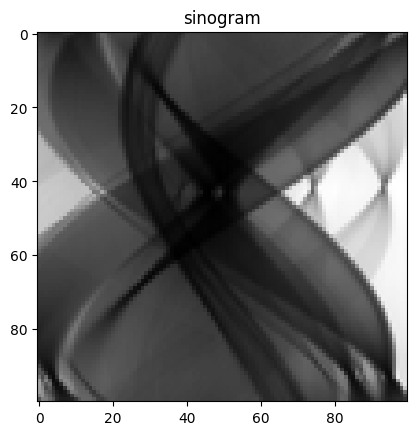

In [ ]:
# samv_tf_fixed.py
# Fixed TensorFlow SAMV implementation (stable solves + stochastic option)
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import tensorflow as tf

# ------------------- helper functions -------------------
def system_matrix_parallel_beam(n_pix=200, n_detectors=100, n_angles=180, extent=1.0):
    """
    Crude parallel-beam system matrix: returns dense A, xgrid, ygrid, angles.
    (Keep as-is for now; consider replacing with a sparse/accurate Siddon projector.)
    """
    x = np.linspace(-extent/2, extent/2, n_pix)
    y = np.linspace(-extent/2, extent/2, n_pix)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    Xc, Yc = np.meshgrid(x, y, indexing='xy')
    pixel_centers = np.column_stack((Xc.ravel(), Yc.ravel()))

    angles = np.linspace(0, np.pi, n_angles, endpoint=False)
    det_pos = np.linspace(-extent/2, extent/2, n_detectors)

    M = n_detectors * n_angles
    K = n_pix * n_pix
    A = np.zeros((M, K), dtype=np.float32)

    for a_idx, th in enumerate(angles):
        det_axis = np.array([-np.sin(th), np.cos(th)], dtype=np.float32)
        for d_idx, d in enumerate(det_pos):
            row = a_idx * n_detectors + d_idx
            dist = np.dot(pixel_centers, det_axis) - d
            mask = np.abs(dist) < max(dx, dy)/2
            A[row, mask] = 1.0
    return A, x, y, angles

# ------------------- SAMV (TF) -------------------
def samv_tf(X, A,
            p0=None, sigma0=None,
            max_iters=200, tol=1e-6,
            min_p=1e-12, min_sigma=1e-8,
            reg_coef=1e-6,   # stronger default regularization
            gamma_p=0.3, gamma_sigma=0.3,
            stochastic=False,
            n_detectors=None, n_angles=None,
            n_angle_samples=10,
            verbose=False):
    """
    TensorFlow SAMV (stable, using linear solves). Works in eager mode.
    - X: (M, N) numpy array or tf.Tensor (real). We'll cast to tf.complex64.
    - A: (M, K) numpy array or tf.Tensor (real or complex). We'll cast to tf.complex64.
    - If stochastic=True, you MUST provide n_detectors and n_angles so rows can be sampled by angle.
    """
    # Cast inputs to tensors of correct dtype
    X = tf.convert_to_tensor(X)
    A = tf.convert_to_tensor(A)
    # If real inputs, cast to complex
    if X.dtype.is_floating:
        Xc = tf.cast(X, tf.complex64)
    else:
        Xc = tf.cast(X, tf.complex64)
    if A.dtype.is_floating:
        Ac = tf.cast(A, tf.complex64)
    else:
        Ac = tf.cast(A, tf.complex64)

    # Dimensions (use tf.shape for safety)
    M = int(Ac.shape[0])
    K = int(Ac.shape[1])
    # N from X (snapshots). Accept X shape (M,N) or (M,1)
    if len(Xc.shape) == 1:
        Xc = tf.reshape(Xc, (M, 1))
    N = int(Xc.shape[1])

    # Sample covariance (complex)
    Rn = (Xc @ tf.transpose(tf.math.conj(Xc))) / tf.cast(N, tf.complex64)

    # Initialize p and sigma (float32)
    if p0 is None:
        p = tf.ones([K], dtype=tf.float32) * 1e-2
    else:
        p = tf.convert_to_tensor(p0, dtype=tf.float32)
        p = tf.reshape(p, (K,))

    if sigma0 is None:
        # simple estimate: small positive scalar
        sigma = tf.constant(1e-3, dtype=tf.float32)
    else:
        sigma = tf.constant(float(sigma0), dtype=tf.float32)

    # Identity used for solves
    I_M = tf.cast(tf.eye(M), tf.complex64)

    history = {'p': [], 'sigma': []}
    eps = 1e-12

    for it in range(max_iters):
        # Optionally sample subset of angles
        if stochastic:
            if n_detectors is None or n_angles is None:
                raise ValueError("stochastic=True requires n_detectors and n_angles")
            # pick angles indices
            angle_idx = tf.random.shuffle(tf.range(n_angles))[:n_angle_samples]
            # build rows = angle_idx * n_detectors + [0..n_detectors-1]
            det_range = tf.range(n_detectors, dtype=tf.int32)
            rows = tf.reshape(angle_idx[:, None] * n_detectors + det_range[None, :], [-1])
            # gather subset
            A_sub = tf.gather(Ac, rows, axis=0)
            X_sub = tf.gather(Xc, rows, axis=0)
            M_sub = int(A_sub.shape[0])
            Rn_sub = (X_sub @ tf.transpose(tf.math.conj(X_sub))) / tf.cast(X_sub.shape[1], tf.complex64)
            AP = A_sub * tf.cast(p[tf.newaxis, :], tf.complex64)
            R = AP @ tf.transpose(tf.math.conj(A_sub)) + tf.cast(sigma, tf.complex64) * tf.eye(M_sub, dtype=tf.complex64)
            # regularize (stronger)
            traceR = tf.math.real(tf.linalg.trace(R))
            reg = reg_coef * (traceR / tf.cast(M_sub, tf.float32))
            R = R + tf.cast(reg, tf.complex64) * tf.eye(M_sub, dtype=tf.complex64)
            # For solves use R (M_sub x M_sub)
            # Solve operations below use this R and Rn_sub and A_sub
            R_curr = R
            Rn_curr = Rn_sub
            A_curr = A_sub
            I_curr = tf.eye(M_sub, dtype=tf.complex64)
            M_curr = M_sub
        else:
            # full data
            AP = Ac * tf.cast(p[tf.newaxis, :], tf.complex64)
            R = AP @ tf.transpose(tf.math.conj(Ac)) + tf.cast(sigma, tf.complex64) * tf.eye(M, dtype=tf.complex64)
            traceR = tf.math.real(tf.linalg.trace(R))
            reg = reg_coef * (traceR / tf.cast(M, tf.float32))
            R = R + tf.cast(reg, tf.complex64) * tf.eye(M, dtype=tf.complex64)
            R_curr = R
            Rn_curr = Rn
            A_curr = Ac
            I_curr = I_M
            M_curr = M

        # Solve linear systems using tf.linalg.solve (multiple RHS allowed)
        # We need R^{-1} * A_curr  and R^{-1} * Rn_curr  (and further solves using those)
        # Compute RinvA = R^{-1} * A_curr
        # Use tf.linalg.solve: solves R X = B for X
        try:
          RinvA = tf.linalg.solve(R_curr, A_curr)            # shape (M_curr, K)
        except:
          print(R_curr.shape)
          print((1e-6 * np.eye(M_curr)).shape)
          R_curr = R_curr + 1e-4 * np.eye(M_curr)
          RinvA = tf.linalg.solve(R_curr, A_curr)
        denom_c = tf.reduce_sum(tf.math.conj(A_curr) * RinvA, axis=0)   # shape (K,)
        denom = tf.math.real(denom_c)
        # guard denom
        denom = tf.maximum(denom, eps)

        # Compute R^{-1} * Rn_curr  (M_curr x M_curr)
        # then compute R^{-1} * Rn_curr * R^{-1} * A_curr:
        Rinv_Rn = tf.linalg.solve(R_curr, Rn_curr)                     # (M_curr x M_curr)
        Rinv_Rn_Rinv_A = tf.linalg.solve(R_curr, Rinv_Rn @ A_curr)     # (M_curr x K)
        numer_c = tf.reduce_sum(tf.math.conj(A_curr) * Rinv_Rn_Rinv_A, axis=0)
        numer = tf.math.real(numer_c)

        # Update p (float)
        p_update = numer / (denom**2) + p - 1.0 / denom
        # sanitize
        p_update = tf.where(tf.math.is_finite(p_update), p_update, p)
        p_candidate = tf.maximum(min_p, (1.0 - gamma_p) * p + gamma_p * p_update)

        # Sigma update (approx)
        # We need trace(R^{-2}) = trace( (R^{-1})^2 ). Compute Rinv by solving for identity:
        # Rinv = solve(R, I)
        Rinv = tf.linalg.solve(R_curr, I_curr)   # (M_curr x M_curr)
        # Rinv2 = Rinv @ Rinv
        Rinv2 = Rinv @ Rinv
        trace_Rinv2 = tf.math.real(tf.linalg.trace(Rinv2))

        if trace_Rinv2 < eps:
            sigma_candidate = sigma
        else:
            # compute trace(Rinv2 @ Rn_curr)
            t1 = tf.math.real(tf.linalg.trace(Rinv2 @ Rn_curr))
            trace_Rinv = tf.math.real(tf.linalg.trace(Rinv))
            term = t1 + sigma * trace_Rinv2 - trace_Rinv
            sigma_update = term / (trace_Rinv2 + eps)
            sigma_update = tf.where(tf.math.is_finite(sigma_update), sigma_update, sigma)
            sigma_candidate = tf.maximum(min_sigma, (1.0 - gamma_sigma) * sigma + gamma_sigma * sigma_update)

        # Convergence check and update
        max_change_p = tf.reduce_max(tf.abs(p_candidate - p))
        max_change = tf.maximum(max_change_p, tf.abs(sigma_candidate - sigma))

        # record and assign
        history['p'].append(p_candidate.numpy())
        history['sigma'].append(float(sigma_candidate.numpy()))

        p = p_candidate
        sigma = sigma_candidate

        if verbose and (it % 1 == 0):
            print(f"iter={it+1}, max_change={max_change:.3e}, sum(p)={tf.reduce_sum(p).numpy():.3e}, sigma={sigma:.3e}")

        if max_change < tol:
            if verbose:
                print("Converged at iter", it+1)
            break

    return p.numpy(), float(sigma.numpy()), history

# ------------------- usage example (synthetic) -------------------
if __name__ == "__main__":
    # small example (keep sizes moderate for this demonstration)
    sinogram = np.zeros((100, 100), dtype=np.float32)
    sinogram[:, 45:55] = 128.0 * np.sin(np.linspace(0, np.pi, 10))[None, :]

    sinogram = np.load("/content/sino_smal.npy").T

    plt.imshow(sinogram, cmap='gray'); plt.title("sinogram"); plt.show()
    n_detectors, n_angles = sinogram.shape

    # Build system matrix (dense, crude)
    A, xgrid, ygrid, angles = system_matrix_parallel_beam(
        n_pix=50,
        n_detectors=n_detectors,
        n_angles=n_angles,
        extent=1.0
    )
    As = sparse.csr_matrix(A)

    # Flatten sinogram
    X = sinogram.flatten()[:, None].astype(np.float32)

    # Convert to TF tensors (dense)
    # WARNING: converting a huge dense A to tf.Tensor may be memory heavy.
    Ac = tf.convert_to_tensor(As.toarray(), dtype=tf.complex64)
    Xc = tf.convert_to_tensor(X, dtype=tf.complex64)

    # Run SAMV (non-stochastic)
    p_est, sigma_est, hist = samv_tf(Xc, Ac, max_iters=10, tol=1e-6,stochastic=False, verbose=True,n_detectors=100,n_angles=100)

    image_est = np.reshape(p_est, (50, 50))
    plt.imshow(image_est, cmap='gray'); plt.title("SAMV reconstruction"); plt.colorbar(); plt.show()
